In [ ]:
%load_ext autoreload
%autoreload 2

import math
import os
import sys
import json
import IPython

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
from matplotlib.colors import Normalize

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import wget

# custom helper functions
from utils import *

In [ ]:
def get_song_data(SPOTIFY_ID):
    song = sp.track(SPOTIFY_ID)
    file = wget.download(song['preview_url'])
    
    return file

def get_mfcc(file, dataset='gtzan', clip=0):
    # constants
    SAMPLE_RATE = 44100  # 44.1 kHz is standard
    DURATION = 30 # measure in seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
    # get MFCC data
    n_mfcc = 13
    n_fft = 2048
    hop_length = 512
    num_segments = 10

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    signal, sr = librosa.load(file, sr=SAMPLE_RATE)
    
    s = clip
    start_sample = num_samples_per_segment * s # s==0 -> 0
    finish_sample = start_sample + num_samples_per_segment # s==0 -> num_samples_per_segment
    
    mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],
                                sr = sr,
                                n_fft = n_fft,
                                n_mfcc = n_mfcc,
                                hop_length = hop_length)
    mfcc = mfcc.T
    
    return signal, sr, mfcc

def predict(model, X):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...]

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    prediction = prediction.reshape((10,)) 

    color_data = [1,2,3,4,5,6,7,8,9,10]
    my_cmap = cm.get_cmap('jet')
    my_norm = Normalize(vmin=0, vmax=10)

    fig,ax= plt.subplots(figsize=(16, 8))

    ax.bar(x=class_labels,
           height=prediction,
           color=my_cmap(my_norm(color_data)))
    ax.set_title("Probability Distribution Of The Given Song Over Different Genres")
  
    plt.show()
    
# class_labels = ['electronic', 'experimental', 'folk', 'hip hop', 'instrumental', 'international', 'pop', 'rock']
class_labels = ['pop',
 'metal',
 'disco',
 'blues',
 'reggae',
 'classical',
 'rock',
 'hiphop',
 'country',
 'jazz'
 ]

## Initialize Spotipy to work with Spotify API, Load Model

In [ ]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

In [4]:
model = keras.models.load_model("/storage/graham/music/models/gtzan_cnn")

2022-05-03 23:37:46.096263: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-03 23:37:46.096307: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 23:37:46.096325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (earhart): /proc/driver/nvidia/version does not exist
2022-05-03 23:37:46.096530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Grab Song Clip, Process Data

In [5]:
ID = "51pshtuYkgUQnt5huMPbKL" # mac miller
# ID = "3AhXZa8sUQht0UEdBJgpGc"  # bob dylan

ID = "08mG3Y1vljYA6bvDt4Wqkj"  # AC/DC

ID = "78lgmZwycJ3nzsdgmPPGNx" # immigrant song

# ID = "2TxCwUlqaOH3TIyJqGgR91" # mamma mia

ID = "0dQZmVKzYF3F9W64ESs8h4" # fur elise

ID = "6ztstiyZL6FXzh4aG46ZPD" # boogie wonderland

ID = "6YffUZJ2R06kyxyK6onezL" # ring of fire

In [6]:
file = get_song_data(ID)
signal, sr, mfcc = get_mfcc(file)
IPython.display.Audio(signal, rate=sr)

100% [..............................................................] 361921 / 361921

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/tmp/ipykernel_237358/3040357103.py:27: FutureWarning: Pass y=[0.         0.         0.         ... 0.01441956 0.01315308 0.00416565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],


/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/tmp/ipykernel_237358/3040357103.py:27: FutureWarning: Pass y=[0.         0.         0.         ... 0.01441956 0.01315308 0.00416565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],


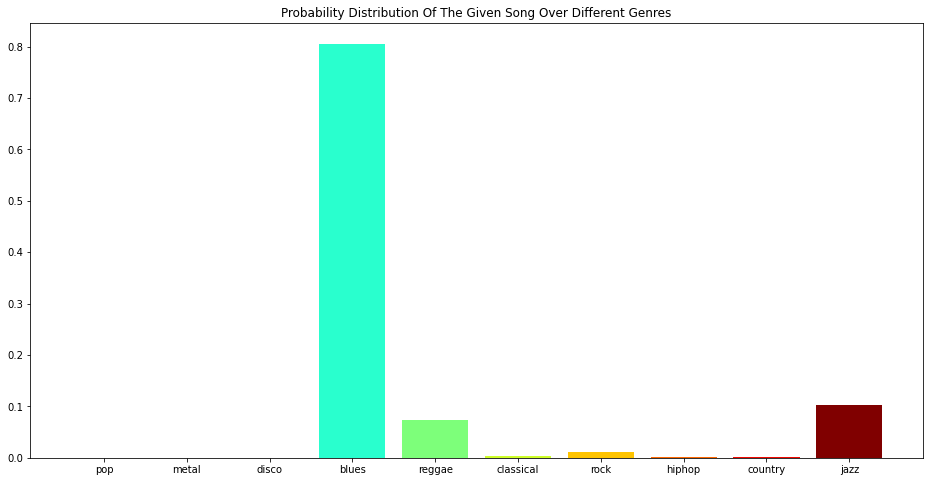

In [13]:
signal, sr, mfcc = get_mfcc(file, clip=0)
tmp = tf.image.resize(mfcc[..., np.newaxis], [130, 13]).numpy()
predict(model, tmp)

## Cleanup Time, Cleanup Time, Everybody Cleanup

In [14]:
os.remove(file)